In [1]:
from pathlib import Path
from itertools import product
import numpy as np
from sklearn.metrics import precision_recall_curve, average_precision_score, confusion_matrix, classification_report
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from custom_shap_plot_function import my_shap_summary

In [2]:
path_FL = Path('../results/finland')
path_NL = Path('../results/netherlands')
path_results = Path('../results/comparison')

### Comparing model performance increase with extra predictors

In [3]:
def load_probas(path):
    dfs = []
    for sex, nback, foldersuffix in product(['men', 'women'], range(1,6), ['', '_hbonly']):
        df = pd.read_pickle(path / f'probas{foldersuffix}' / f'proba_{sex}_{nback}.pkl')
        df['sex'] = sex
        df['nback'] = nback
        df['model'] = 'full' if foldersuffix == '' else 'reduced' 
        dfs.append(df)
    return pd.concat(dfs)

In [4]:
probas_NL = load_probas(path_NL)
probas_FL = load_probas(path_FL)
probas = pd.concat([df.assign(country=k) for k,df in {'FI':probas_FL, 'NL':probas_NL}.items()])
probas = probas.reset_index()
probas = probas.drop_duplicates(subset=['index', 'country', 'model', 'sex'], keep='last')

In [5]:
dfs = []
auprs = []
for name, group in probas.groupby(['sex', 'country', 'model']):
    for i, outcome in enumerate(['low', 'ok']):
        prec, rec, thres = precision_recall_curve(group['HbOK'], group[f'prob_{outcome}'], pos_label=i)
        df = pd.DataFrame({'precision':prec[:-1],
                           'recall':rec[:-1],
                           'thresholds':thres})
        df['sex'] = name[0]
        df['country'] = name[1]
        # df['nback'] = name[2]
        df['model'] = name[2]
        df['outcome'] = outcome
        dfs.append(df)
        
        # defrates[f'{name[0]}-{name[1]}-{name[2]}-{name[3]}-{outcome}'] = np.mean(group['HbOK'] == i)
        # auprs[f'{name[0]}-{name[1]}-{name[2]}-{name[3]}-{outcome}'] = round(average_precision_score(group['HbOK'], group[f'prob_{outcome}'], pos_label=i), 3)
        auprs.append([name[0], name[1], name[2], outcome, 
                      round(average_precision_score(group['HbOK'], group[f'prob_{outcome}'], pos_label=i), 3),
                      np.mean(group['HbOK'] == i)])
        
probasdf = pd.concat(dfs)

In [6]:
auprs = pd.DataFrame(auprs, columns=['sex', 'country', 'model', 'outcome', 'aupr', 'base_prob'])
auprs['aupr_adjusted'] = auprs['aupr'] - auprs['base_prob']
auprs

,sex,country,model,outcome,aupr,base_prob,aupr_adjusted
0,men,FI,full,low,0.114,0.010286,0.103714
1,men,FI,full,ok,0.999,0.989714,0.009286
2,men,FI,reduced,low,0.076,0.010286,0.065714
3,men,FI,reduced,ok,0.998,0.989714,0.008286
4,men,NL,full,low,0.089,0.010963,0.078037
5,men,NL,full,ok,0.998,0.989037,0.008963
6,men,NL,reduced,low,0.083,0.010963,0.072037
7,men,NL,reduced,ok,0.998,0.989037,0.008963
8,women,FI,full,low,0.140,0.025353,0.114647
9,women,FI,full,ok,0.995,0.974647,0.020353


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

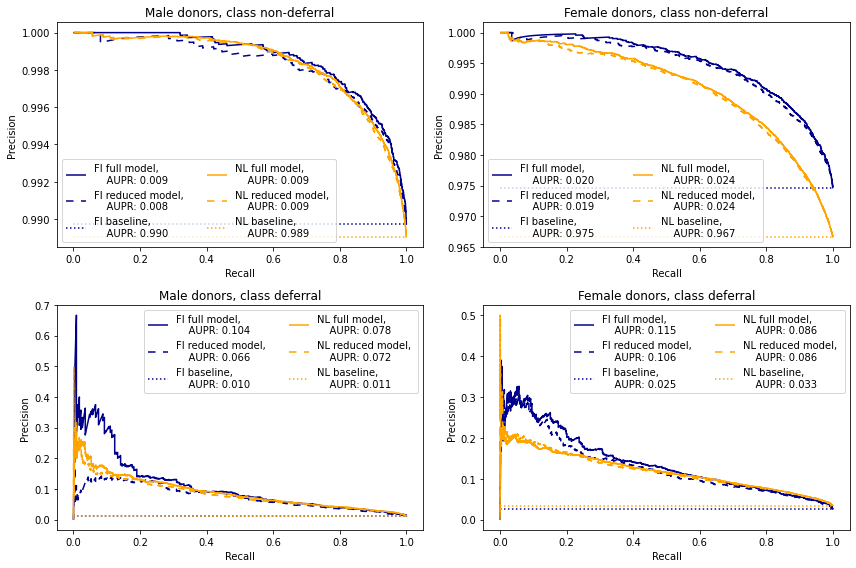

In [7]:
fig, ax = plt.subplots(2, 2, figsize=(12,8))

for (x, sex), (y, outcome) in product(enumerate(['men', 'women']), enumerate(['ok', 'low'])):
    dfsub = probasdf.loc[(probasdf['sex'] == sex) & 
                         (probasdf['outcome'] == outcome), ]
    
    for name, group in dfsub.groupby(['country', 'model']):
        aupr = auprs.loc[(auprs.sex == sex) &
                         (auprs.country == name[0]) &
                         (auprs.model == name[1]) &
                         (auprs.outcome == outcome), 'aupr_adjusted']
        base_prob = auprs.loc[(auprs.sex == sex) &
                              (auprs.country == name[0]) &
                              (auprs.model == name[1]) &
                              (auprs.outcome == outcome), 'base_prob']
        
        ax[y, x].plot(group.recall, group.precision, 
                      label=f'{name[0]} {name[1]} model, \n    AUPR: {float(round(aupr, 3)):.3f}',
                      linestyle='-' if name[1] == 'full' else '--',
                      dashes=(5,0) if name[1] == 'full' else (5, 5),
                      color='darkblue' if name[0] == 'FI' else 'orange')
        
        if name[1] == 'reduced':   
            ax[y, x].hlines(y=base_prob, xmin=0, xmax=1, 
                            linestyles='dotted',
                            color='darkblue' if name[0] == 'FI' else 'orange',
                            label=f'{name[0]} baseline, \n    AUPR: {float(round(base_prob, 3)):.3f}')
        
        ax[0, x].legend(bbox_to_anchor=(0,0), loc='lower left', ncol=2)
        ax[1, x].legend(bbox_to_anchor=(1,1), loc='upper right', ncol=2)
        ax[y, x].set_xlabel('Recall')
        ax[y, x].set_ylabel('Precision')
        
ax[0, 0].set_title('Male donors, class non-deferral')
ax[0, 1].set_title('Female donors, class non-deferral')
ax[1, 0].set_title('Male donors, class deferral')
ax[1, 1].set_title('Female donors, class deferral')

fig.tight_layout()
plt.savefig(path_results / 'PR_curves.png')

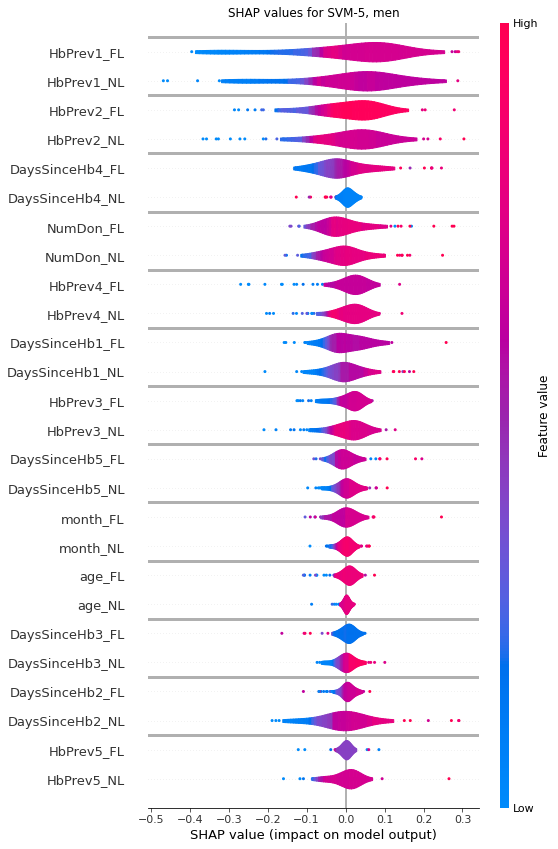

In [3]:
def load_shap_for_plot(sex, nback, foldersuffix):
    filename = f'shapdf_{sex}_{nback}.pkl'
    shapdf_NL = pickle.load(open(path_NL / f'anonshap{foldersuffix}' / filename, 'rb'))
    shapdf_FL = pickle.load(open(path_FL / f'anonshap{foldersuffix}' / filename, 'rb'))

    shapdf = pd.concat([df.assign(country=k) for k,df in {'NL':shapdf_NL, 'FL':shapdf_FL}.items()])
    shapdf['abs_shap'] = np.abs(shapdf['shap'])
    shapdf['maa'] = shapdf.groupby(['variable', 'country'])['abs_shap'].transform('mean')
    shapdf['var_country'] = shapdf['variable'] + '_' + shapdf['country']
    
    df_shap = pd.DataFrame()
    df_x = pd.DataFrame()

    for varname in np.unique(shapdf['var_country']):
        df_shap[varname] = list(shapdf.loc[shapdf['var_country'] == varname, 'shap'])
        df_x[varname] = list(shapdf.loc[shapdf['var_country'] == varname, 'value'])
        
    order_variables = list(shapdf.loc[shapdf['country'] == 'FL', ].sort_values('maa', ascending=False).drop_duplicates(subset=['variable'], keep='first')['variable'])
    order = [i+str(j) for i in order_variables for j in ['_FL','_NL']]
    order_i = [list(df_shap.columns).index(var) for var in order[::-1]]
    
    return df_shap, df_x, order_i

def plot_shap(sex, nback, foldersuffix, save=False):
    df_shap, df_x, order = load_shap_for_plot(sex, nback, foldersuffix)
    my_shap_summary(df_shap.to_numpy(), df_x, plot_type='violin', title=f'SHAP values for SVM-{nback}, {sex}',
                    show=False, max_display=100, order=order)
    if save:
        plt.savefig(path_results / f'{save}.png')
    
plot_shap('women', 5, '_hbonly', save='SHAP_SVM5_women')
plt.clf()
plot_shap('men', 5, '_hbonly', save='SHAP_SVM5_men')

# AUPR comparison for SVM-1 through SVM-5

In [8]:
def load_all_probas():
    dfs = []
    for country, foldersuffix in product(('FI', 'NL'), ('','_hbonly')):
        df = load_probas(path_NL if country == 'NL' else path_FL)
        df['country'] = country
        dfs.append(df)
    return pd.concat(dfs)

In [9]:
probas = load_all_probas()
def_m_FL = 1-np.mean(probas.loc[(probas.country == 'FI') & (probas.sex == 'men') & (probas.nback == 1), 'HbOK'])
def_f_FL = 1-np.mean(probas.loc[(probas.country == 'FI') & (probas.sex == 'women') & (probas.nback == 1), 'HbOK'])
defs_FL = (def_m_FL, def_f_FL)

def_m_NL = 1-np.mean(probas.loc[(probas.country == 'NL') & (probas.sex == 'men') & (probas.nback == 1), 'HbOK'])
def_f_NL = 1-np.mean(probas.loc[(probas.country == 'NL') & (probas.sex == 'women') & (probas.nback == 1), 'HbOK'])
defs_NL = (def_m_NL, def_f_NL)

In [11]:
auprs = []
for name, group in probas.groupby(['sex', 'country', 'model', 'nback']):
    aupr_0 = round(average_precision_score(group.HbOK, group.prob_low, pos_label=0), 3)
    aupr_1 = round(average_precision_score(group.HbOK, group.prob_ok, pos_label=1), 3)
    defrates = defs_FL if name[1] == 'FI' else defs_NL
    defrate = defrates[0] if name[0] == 'men' else defrates[1]
    ls = list(name)
    ls.extend([aupr_0, aupr_1, defrate])
    auprs.append(ls)
    
auprs = pd.DataFrame(auprs, columns=['sex', 'country', 'model', 'nback', 'aupr_low', 'aupr_ok', 'defrate'])
auprs['aupr_low_adj'] = auprs.aupr_low - auprs.defrate
auprs['aupr_ok_adj'] = auprs.aupr_ok - (1 - auprs.defrate)
auprs.head()

,sex,country,model,nback,aupr_low,aupr_ok,defrate,aupr_low_adj,aupr_ok_adj
0,men,FI,full,1,0.078,0.998,0.010286,0.067714,0.008286
1,men,FI,full,2,0.090,0.998,0.010286,0.079714,0.008286
2,men,FI,full,3,0.107,0.999,0.010286,0.096714,0.009286
3,men,FI,full,4,0.114,0.999,0.010286,0.103714,0.009286
4,men,FI,full,5,0.124,0.999,0.010286,0.113714,0.009286


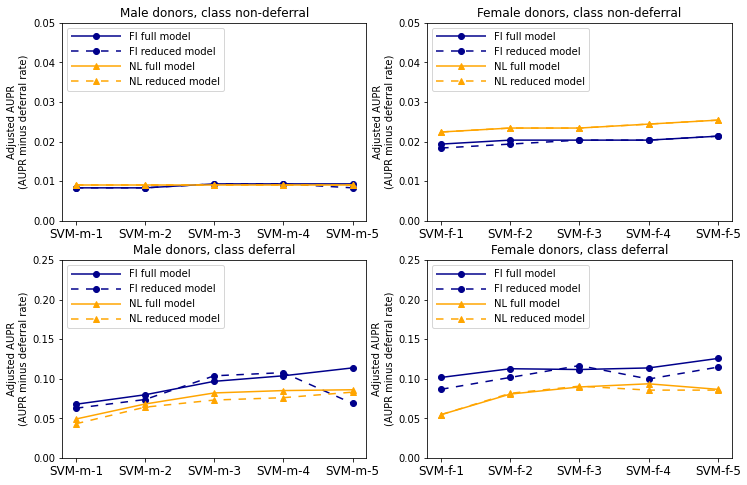

In [14]:
fig, ax = plt.subplots(2, 2, figsize=(12,8))

for name, group in auprs.groupby(['sex', 'country', 'model']):
    x = 1 if name[0] == 'women' else 0
    cname = name[1] 
    sex = 'f' if name[0] == 'women' else 'm'
    xticks = ['SVM-' + sex + '-' + str(n) for n in range(1,6)]
    
    for outcome in ('low', 'ok'):
        y = 0 if outcome == 'ok' else 1
        col = group.aupr_low_adj if outcome == 'low' else group.aupr_ok_adj
    
        ax[y, x].plot(group.nback, col, 
                   marker='o' if name[1] == 'FI' else '^', 
                   linestyle='-' if name[2] == 'full' else '--',
                   dashes=(5,0) if name[2] == 'full' else (5, 5),
                   color='darkblue' if name[1] == 'FI' else 'orange',
                   label=f'{cname} {name[2]} model')
        ax[y, x].set_xticks(np.unique(group.nback))
        ax[y, x].set_xticklabels(xticks, size='large')
        ax[y, x].set_ylabel('Adjusted AUPR\n(AUPR minus deferral rate)')
        ax[y, x].legend(loc = 'upper left', handlelength=5)
        
    ax[0, x].set_ylim(0, 0.05)
    ax[1, x].set_ylim(0, 0.25)
    
ax[0, 1].set_title('Female donors, class non-deferral')
ax[0, 0].set_title('Male donors, class non-deferral')
ax[1, 1].set_title('Female donors, class deferral')
ax[1, 0].set_title('Male donors, class deferral')

# plt.show()
plt.savefig(path_results / 'AUPR_by_submodel.png')